### Import libraries and datasets:

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

In [55]:
csv_fts = "FTS Historical Data.csv"
csv_mwg = "MWG Historical Data.csv"
csv_vic = "VIC Historical Data.csv"



df_fts = pd.read_csv(csv_fts, thousands=',')
df_mwg = pd.read_csv(csv_mwg, thousands=',')
df_vic = pd.read_csv(csv_vic, thousands=',')

### Dataset 1: FTS

- Cast Date column to datetime type
- Sort data ascending by Date

In [56]:
df_fts['Date'] = pd.to_datetime(df_fts['Date'])
df_fts = df_fts.sort_values(by='Date', ascending=True)
df_fts.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,5788,5859,5859,5788,103.55K,-0.0121
1358,2018-01-03,5954,5765,5977,5741,245.02K,0.0286
1357,2018-01-04,6025,5954,6143,5907,167.80K,0.0119
1356,2018-01-05,5883,5977,6048,5883,113.88K,-0.0235
1355,2018-01-08,6001,5859,6001,5765,63.36K,0.0201


- Split Price data
- Reset index

In [57]:
df_price = df_fts[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,5788
1,5954
2,6025
3,5883
4,6001


- Scale data between 0 and 1:

In [58]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.000000
1,0.003602
2,0.005143
3,0.002061
4,0.004622


- Split data into train, test, val (7 - 2 - 1):

In [59]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


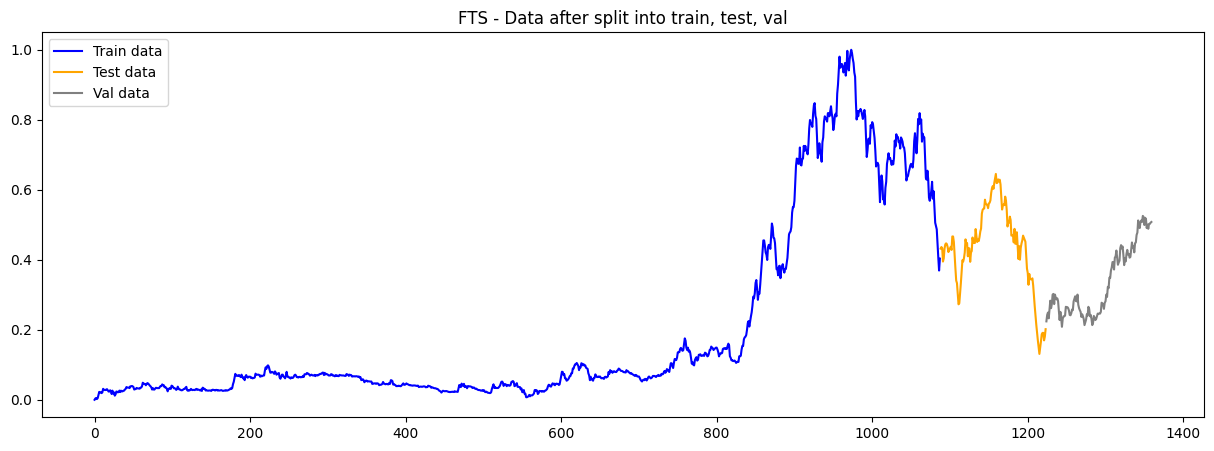

In [60]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('FTS - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [61]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)]
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [62]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Model training:

Kernel: linear, poly, rbf, sigmoid, precomputed

In [63]:
model_svr = SVR(kernel='rbf')
model_svr.fit(x_train, y_train)

SVR()

- Model Prediction on test, val (one-step prediction):

In [64]:
y_pred_test = model_svr.predict(x_test)
y_pred_val = model_svr.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

- 30 days prediction:

In [65]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags)
    y_hat = model_svr.predict(x_input)
    temp_input.append(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.append(y_hat[0])
    i += 1


In [66]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[26826.96918876],
       [27286.50128901],
       [27700.7534765 ],
       [28068.99736885],
       [28406.48172399],
       [28776.66104362],
       [29121.80595042],
       [29451.53591389],
       [29728.35393326],
       [29993.25253506],
       [30238.10041218],
       [30506.4292355 ],
       [30809.52391417],
       [31032.10984404],
       [31196.04875042],
       [31267.84441396],
       [31310.96973454],
       [31429.68923272],
       [31534.62085559],
       [31645.52703734],
       [31715.08544219],
       [31725.57591793],
       [31762.15067481],
       [31756.3216399 ],
       [31765.10985927],
       [31813.11436267],
       [31843.7017609 ],
       [31885.31495643],
       [31908.57473134],
       [31941.82106304]])

- Model evaluating (RMSE - MAPE - MSLE):

In [67]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 29077.268
Validating RMSE: 24012.1691
Predicting 30 days RMSE: 30520.1915

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 98.0387
Validating MSLE: 95.293
Predicting 30 days MSLE: 98.6617


- Prediction plotting:

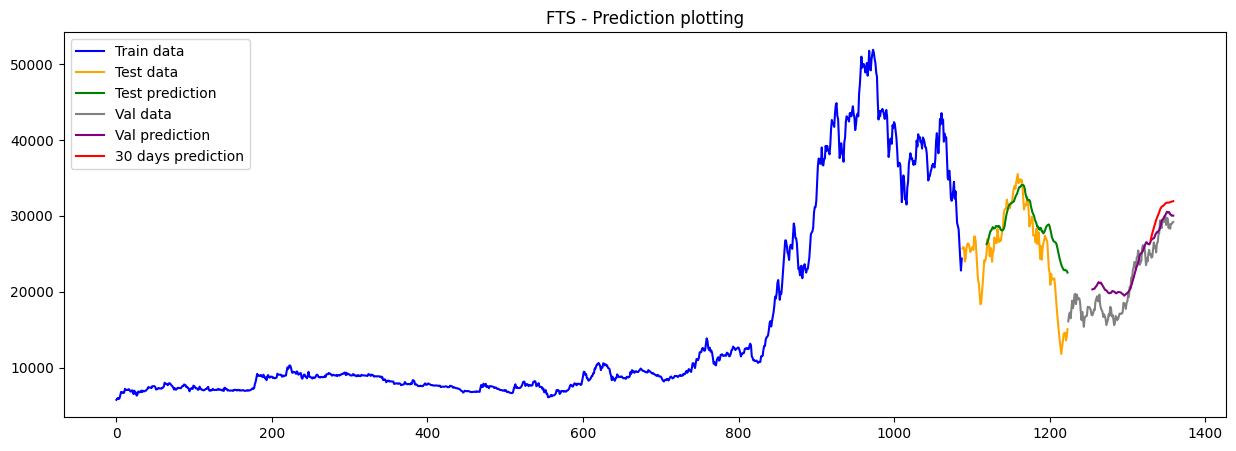

In [68]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('FTS - Prediction plotting')
plt.show()

### Dataset 2: MWG

In [69]:
df_mwg['Date'] = pd.to_datetime(df_mwg['Date'])
df_mwg = df_mwg.sort_values(by='Date', ascending=True)
df_mwg.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,31276,31039,31394,31039,2.27M,0.01
1358,2018-01-03,31892,31323,32034,31276,4.53M,0.02
1357,2018-01-04,31963,31773,32081,31750,2.71M,0.00
1356,2018-01-05,31608,31987,31987,31465,2.93M,-0.01
1355,2018-01-08,31110,31394,31513,31039,3.01M,-0.02


- Split Price data
- Reset index

In [70]:
df_price = df_mwg[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,31276
1,31892
2,31963
3,31608
4,31110


- Scale data between 0 and 1:

In [71]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.200020
1,0.210221
2,0.211397
3,0.205518
4,0.197271


- Split data into train, test, val (7 - 2 - 1):

In [72]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


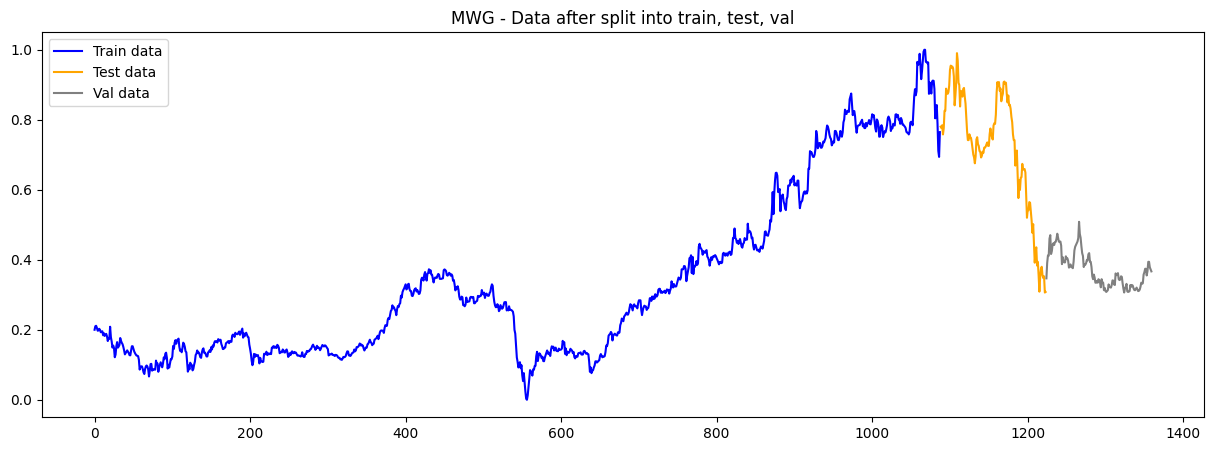

In [73]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('MWG - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [74]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)]
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [75]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Model training:

In [76]:
model_svr = SVR(kernel='rbf')
model_svr.fit(x_train, y_train)

SVR()

- Model Prediction on test, val (one-step prediction):

In [77]:
y_pred_test = model_svr.predict(x_test)
y_pred_val = model_svr.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

- 30 days prediction:

In [78]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags)
    y_hat = model_svr.predict(x_input)
    temp_input.append(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.append(y_hat[0])
    i += 1


In [79]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[39252.1754208 ],
       [39274.15782181],
       [39297.90136512],
       [39301.49808605],
       [39312.94711968],
       [39307.80153657],
       [39307.81144179],
       [39326.78092726],
       [39367.54049754],
       [39406.35471466],
       [39429.86843116],
       [39456.38171082],
       [39497.87267434],
       [39555.86580661],
       [39550.7582691 ],
       [39554.80307769],
       [39553.03889737],
       [39518.91564848],
       [39509.62509676],
       [39511.0545933 ],
       [39515.80794579],
       [39509.35262446],
       [39495.18294517],
       [39504.17024419],
       [39535.75179671],
       [39593.88675881],
       [39641.83299836],
       [39681.75282954],
       [39702.44219723],
       [39756.45374864]])

- Model evaluating (RMSE - MAPE - MSLE):

In [80]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 65098.7439
Validating RMSE: 42539.6585
Predicting 30 days RMSE: 39474.2095

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 111.4766
Validating MSLE: 107.0531
Predicting 30 days MSLE: 105.914


- Prediction plotting:

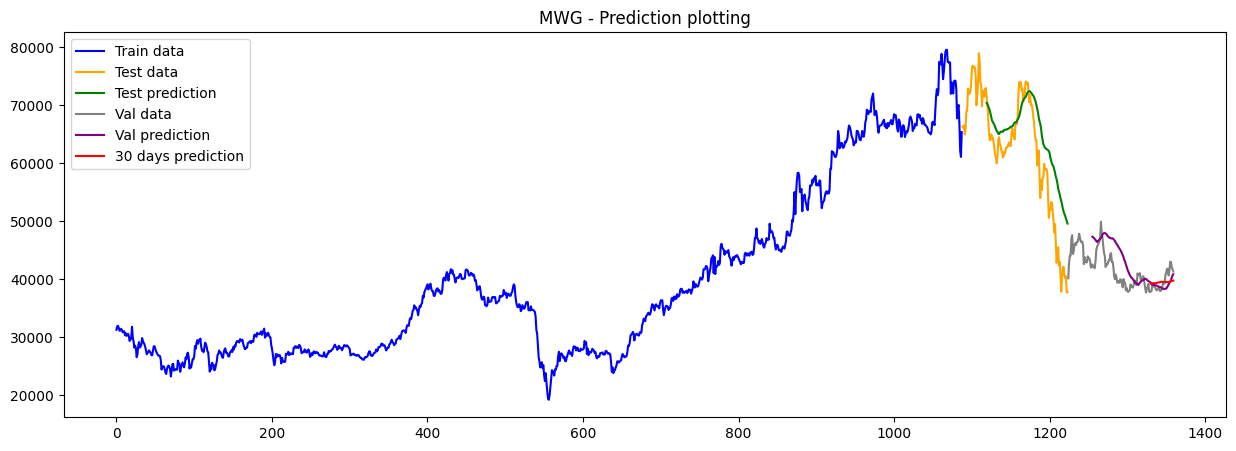

In [81]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('MWG - Prediction plotting')
plt.show()

- Prediction plotting:

### Dataset 3: VIC

In [82]:
df_vic['Date'] = pd.to_datetime(df_vic['Date'])
df_vic = df_vic.sort_values(by='Date', ascending=True)
df_vic.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,64628,64132,64876,63967,1.74M,1.16%
1358,2018-01-03,66529,65702,68760,64959,6.07M,2.94%
1357,2018-01-04,66942,67355,68678,66529,3.55M,0.62%
1356,2018-01-05,66116,66942,66942,65289,3.42M,-1.23%
1355,2018-01-08,66364,66116,67686,65372,4.81M,0.38%


- Split Price data
- Reset index

In [83]:
df_price = df_vic[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,64628
1,66529
2,66942
3,66116
4,66364


- Scale data between 0 and 1:

In [84]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.182297
1,0.206826
2,0.212155
3,0.201497
4,0.204697


- Split data into train, test, val (7 - 2 - 1):

In [85]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


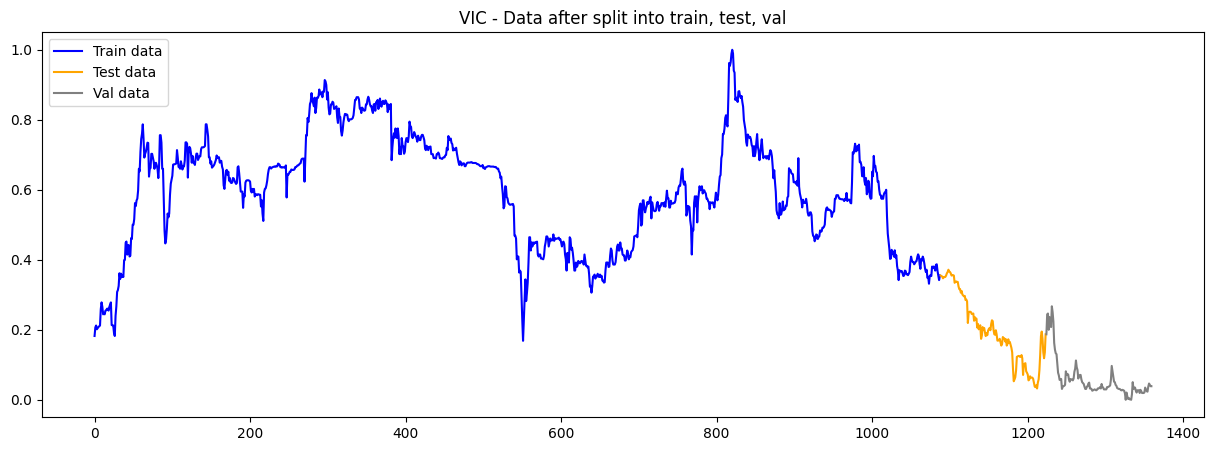

In [86]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('VIC - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [87]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)]
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [88]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Model training:

In [89]:
model_svr = SVR(kernel='rbf')
model_svr.fit(x_train, y_train)

SVR()

- Model Prediction on test, val (one-step prediction):

In [90]:
y_pred_test = model_svr.predict(x_test)
y_pred_val = model_svr.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

- 30 days prediction:

In [91]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags)
    y_hat = model_svr.predict(x_input)
    temp_input.append(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.append(y_hat[0])
    i += 1


In [92]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[93799.56195704],
       [93767.62086128],
       [93861.79429118],
       [94028.32847523],
       [94328.79191489],
       [94571.96950459],
       [94737.99779033],
       [94889.67581819],
       [95034.44074686],
       [95094.69121518],
       [95160.63165006],
       [95227.91975128],
       [95300.97659537],
       [95367.50309867],
       [95426.89736574],
       [95491.49514632],
       [95548.81358701],
       [95613.74829741],
       [95681.35711472],
       [95786.28426186],
       [95888.7392543 ],
       [96086.69756232],
       [96404.55584258],
       [96723.83192998],
       [97097.22592058],
       [97196.5508779 ],
       [97322.6620112 ],
       [97559.14500055],
       [97799.61691394],
       [98342.41760603]])

- Model evaluating (RMSE - MAPE - MSLE):

In [93]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 86179.2407
Validating RMSE: 93420.6501
Predicting 30 days RMSE: 95645.5828

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 125.8354
Validating MSLE: 130.1371
Predicting 30 days MSLE: 130.9428


- Prediction plotting:

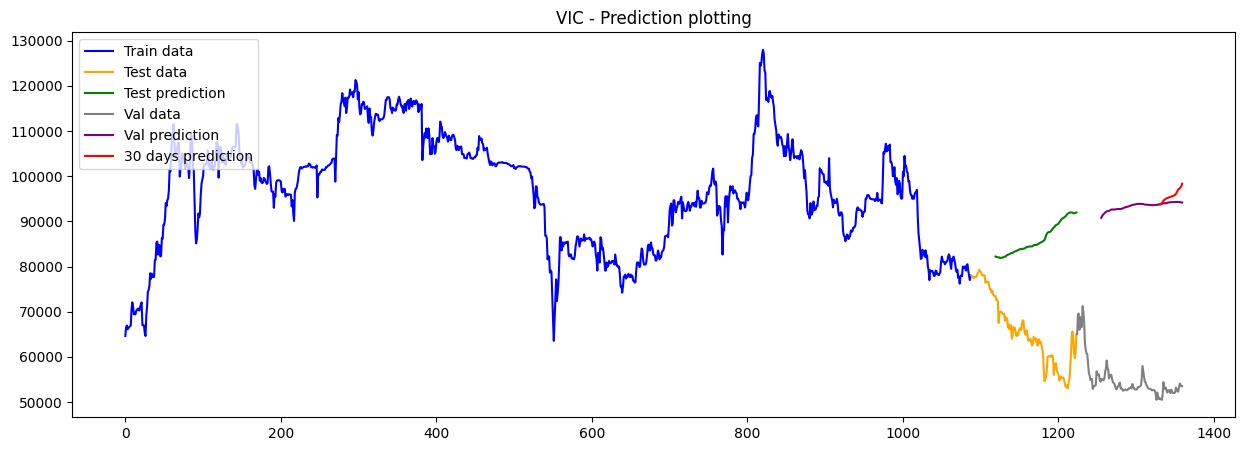

In [94]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('VIC - Prediction plotting')
plt.show()